In [1]:
import sys
sys.path.append("../") # go to parent dir

%load_ext autoreload
%autoreload 2

In [2]:
from evrp.utils.utilities import create_optimal_edges, create_json_out, update_instance_json, read_instance_json_str, convert_txt_instances_to_csv, trace_routes
from evrp.utils.plot import plot_interactive_graph, plot_evrptwv2g
from evrp.milp.evrptw import EVRPTW

import pandas as pd
import numpy as np

import json

pd.options.plotting.backend = "plotly"

# Convert Schneider instance to E-VRP-TW-V2G

In [3]:
schneider_instance = 'rc105C5'
convert_txt_instances_to_csv(schneider_instance)

 # Full solve

Objective options: {Schneider} OR {OpEx CapEx Cycle EA DCM Delivery}

Constraint options: {Start=End, FullStart=End, NoXkappaBounds, NoMinVehicles, NoSymmetry, NoXd, SplitXp, StationaryEVs}

In [61]:
instance = 'r105C5_e'
fpath = 'config/test_instances/' + instance + '.csv'

In [192]:
m = EVRPTW(problem_type='Schneider Cycle nosymmetry stationaryevs splitxp bigm')
m.full_solve(fpath)

2021-07-01 12:49:35 INFO     Building abstract model
2021-07-01 12:49:35 INFO     Defining parameters and sets
2021-07-01 12:49:35 INFO     Defining variables
2021-07-01 12:49:35 INFO     Defining constraints
2021-07-01 12:49:35 INFO     Importing EVRPTW MILP instance: r105C5_e
2021-07-01 12:49:35 INFO     Reading CSV
2021-07-01 12:49:35 INFO     Creating graph
2021-07-01 12:49:35 INFO     Creating timeseries data
2021-07-01 12:49:35 INFO     Creating duplicates and extended graph
2021-07-01 12:49:35 INFO     Using Scipy euclidian distances to generate distance matrix
2021-07-01 12:49:35 INFO     Calculating distance matrix
2021-07-01 12:49:35 INFO     Creating parameters
2021-07-01 12:49:35 INFO     Creating instance
2021-07-01 12:49:36 INFO     Problem type: Schneider Cycle nosymmetry stationaryevs splitxp bigm
2021-07-01 12:49:42 INFO     Solving instance...


Using license file /Users/ramiariss/gurobi.lic
Academic license - for non-commercial use only - expires 2021-08-14
Read LP format model from file /var/folders/vv/1p3h17yx43n9m7k86th68_ym0000gn/T/tmpz0q9o252.pyomo.lp
Reading time = 0.05 seconds
x6949: 19469 rows, 3913 columns, 43296 nonzeros
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 19469 rows, 3913 columns and 43296 nonzeros
Model fingerprint: 0x42b4c224
Variable types: 457 continuous, 3456 integer (3456 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+02]
  Objective range  [4e+00, 1e+03]
  Bounds range     [1e+00, 2e+02]
  RHS range        [1e+00, 6e+02]
Presolve removed 10972 rows and 971 columns
Presolve time: 0.33s
Presolved: 8497 rows, 2942 columns, 29963 nonzeros
Variable types: 171 continuous, 2771 integer (2771 bi

2021-07-01 12:49:46 INFO     Done


In [193]:
for k, v in m.instance.xgamma.get_values().items():
    if v>0:
        print(k)


('D0', 'C28')
('S0_0', 'S0_2')
('S0_2', 'S0_3')
('S0_3', 'S0_0')
('S1_0', 'C75')
('S13_0', 'C95')
('C91', 'S13_0')
('C28', 'C78')
('C75', 'C91')
('C78', 'S1_0')
('C95', 'D1')


In [194]:
print(m.results)


Problem: 
- Name: x6949
  Lower bound: 1137.6131829286858
  Upper bound: 1137.6131829286858
  Number of objectives: 1
  Number of constraints: 19469
  Number of variables: 3913
  Number of binary variables: 3456
  Number of integer variables: 3456
  Number of continuous variables: 457
  Number of nonzeros: 43296
  Sense: minimize
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Wall time: 1.4069697856903076
  Error rc: 0
  Time: 1.6147949695587158
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [195]:
m.instance.xkappa.get_values()

{('S0_0', 0): -0.0,
 ('S0_0', 10): -0.0,
 ('S0_0', 20): -0.0,
 ('S0_0', 30): -0.0,
 ('S0_0', 40): -0.0,
 ('S0_0', 50): -0.0,
 ('S0_0', 60): -0.0,
 ('S0_0', 70): -0.0,
 ('S0_0', 80): -0.0,
 ('S0_0', 90): -0.0,
 ('S0_0', 100): -0.0,
 ('S0_0', 110): -0.0,
 ('S0_0', 120): -0.0,
 ('S0_0', 130): -0.0,
 ('S0_0', 140): -0.0,
 ('S0_0', 150): -0.0,
 ('S0_0', 160): -0.0,
 ('S0_0', 170): -0.0,
 ('S0_0', 180): -0.0,
 ('S0_0', 190): -0.0,
 ('S0_0', 200): -0.0,
 ('S0_0', 210): -0.0,
 ('S0_0', 220): -0.0,
 ('S0_1', 0): -0.0,
 ('S0_1', 10): -0.0,
 ('S0_1', 20): -0.0,
 ('S0_1', 30): -0.0,
 ('S0_1', 40): -0.0,
 ('S0_1', 50): -0.0,
 ('S0_1', 60): -0.0,
 ('S0_1', 70): -0.0,
 ('S0_1', 80): -0.0,
 ('S0_1', 90): -0.0,
 ('S0_1', 100): -0.0,
 ('S0_1', 110): -0.0,
 ('S0_1', 120): -0.0,
 ('S0_1', 130): -0.0,
 ('S0_1', 140): -0.0,
 ('S0_1', 150): -0.0,
 ('S0_1', 160): -0.0,
 ('S0_1', 170): -0.0,
 ('S0_1', 180): -0.0,
 ('S0_1', 190): -0.0,
 ('S0_1', 200): -0.0,
 ('S0_1', 210): -0.0,
 ('S0_1', 220): -0.0,
 ('S0_2', 

2021-07-01 12:50:20 WARNING  0


IndexError: index 0 is out of bounds for axis 0 with size 0

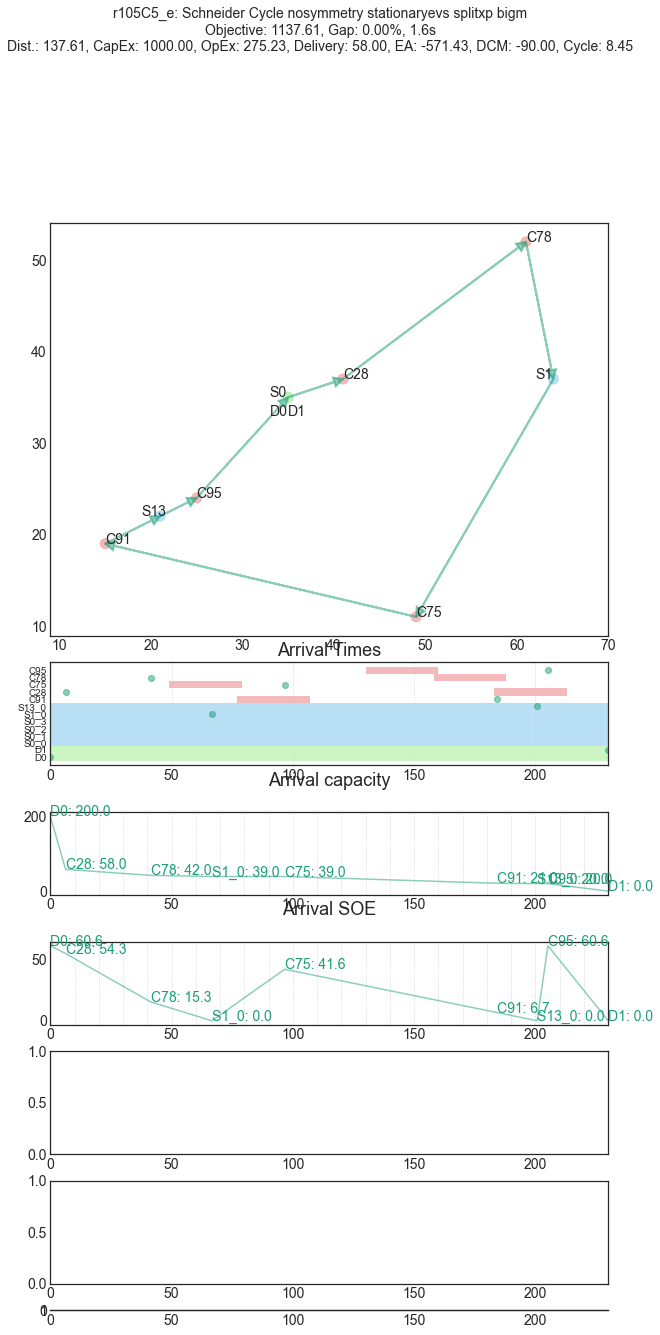

In [196]:
x, xp, traces, routes = plot_evrptwv2g(m, save=False)

In [83]:
dfs = []
for k, v in {'xp': m.instance.xp, 'xc': m.instance.xc, 'xg': m.instance.xg}.items():
    dfs.append(pd.DataFrame.from_dict(data=v.get_values(), orient='index', columns=[k]))
df = pd.concat(dfs, axis=1)
df[(df>0).any(axis=1)]

,xp,xc,xg
"(S0_0, 232)",0.288184,0.288184,0.0
"(S0_0, 236)",0.288184,0.288184,0.0
"(S0_0, 240)",0.288184,0.288184,0.0
"(S0_0, 244)",0.288184,0.288184,0.0
"(S0_0, 248)",0.288184,0.288184,0.0
"(S0_0, 252)",0.288184,0.288184,0.0
"(S0_0, 256)",0.288184,0.288184,0.0
"(S0_0, 260)",0.288184,0.288184,0.0
"(S0_0, 264)",0.288184,0.288184,0.0
"(S0_0, 268)",0.288184,0.288184,0.0


In [84]:
routes

state           xw     xq         xa
from  to                                         
D0    C98      1.0     0.000000  200.0  77.750000
      D0       NaN     0.000000  200.0  77.750000
C98   C65      1.0   126.400549  180.0  41.349451
C65   S0_0     1.0   229.206798   60.0  28.543202
S0_0  C20      1.0   782.000000   60.0  77.678649
C20   C24      1.0   877.000000   50.0  72.678649
C24   S15_0    1.0   994.784888   40.0  44.893761
S15_0 C57      1.0  1039.045361   40.0  35.923328
C57   D1       1.0  1236.000000    0.0   0.000000

In [21]:
trace_routes(m)

[('D0', 'S1_0', 'M1', 'M2', 'S2_0', 'S0_1', 'D1'),
 ('D0', 'S3_0', 'M3', 'S6_0', 'M6', 'S5_0', 'M5', 'M4', 'S0_0', 'D1')]

In [79]:
m.data['d']

,D0,D1,S0_0,S0_1,S15_0,S15_1,C20,C98,C65,C57,C24
D0,0.000000,0.000000,0.000000,0.000000,24.020824,24.020824,10.000000,30.805844,12.806248,35.000000,15.000000
D1,0.000000,0.000000,0.000000,0.000000,24.020824,24.020824,10.000000,30.805844,12.806248,35.000000,15.000000
S0_0,0.000000,0.000000,0.000000,0.000000,24.020824,24.020824,10.000000,30.805844,12.806248,35.000000,15.000000
S0_1,0.000000,0.000000,0.000000,0.000000,24.020824,24.020824,10.000000,30.805844,12.806248,35.000000,15.000000
S15_0,24.020824,24.020824,24.020824,24.020824,0.000000,0.000000,25.632011,52.554733,16.643317,11.045361,27.784888
S15_1,24.020824,24.020824,24.020824,24.020824,0.000000,0.000000,25.632011,52.554733,16.643317,11.045361,27.784888
C20,10.000000,10.000000,10.000000,10.000000,25.632011,25.632011,0.000000,37.536649,20.591260,36.400549,5.000000
C98,30.805844,30.805844,30.805844,30.805844,52.554733,52.554733,37.536649,0.000000,36.400549,62.641839,41.400483
C65,12.806248,12.806248,12.806248,12.806248,16.643317,16.643317,20.591260,36.400549,0.000000,26.248809,25.079872
C57,35.000000,35.000000,35.000000,35.000000,11.045361,11.045361,36.400549,62.641839,26.248809,0.000000,38.078866


# Archive, fix route, modify objective, and warmstart solve

In [ ]:
m.archive_instance_result()

In [ ]:
m.fix_variables(['xgamma'])

In [ ]:
m.remake_objective(m.instance, 'Opex Capex EA DCM cycle')

In [ ]:
m.warmstart_solve()

In [ ]:
print(m.results)

In [ ]:
x, xp, traces, routes = plot_evrptwv2g(m)

# Archive, rebuild model to modify constraints, fix route, warmstart solve

In [ ]:
m.archive_instance_result()

In [ ]:
m.instance_archive

In [ ]:
m.remake_model('Opex Capex EA DCM cycle wsplitxgamma', fpath)

In [ ]:
m.set_xgamma('Opex Capex EA DCM cycle')

In [ ]:
m.fix_variables(['xgamma'])

In [ ]:
m.make_solver(solve_options={'TimeLimit': 60 * 5})

In [ ]:
m.warmstart_solve()

In [ ]:
x, xp, traces, routes = plot_evrptwv2g(m)

In [ ]:
routes

# Check infeasible constraints

In [ ]:
from pyomo.util.infeasible import log_infeasible_constraints

In [ ]:
log_infeasible_constraints(m.instance)